## Pre-Processing

In [4]:
from source import data_import
from source.constants import CHANNELS, DEFAULT_PATIENTS
import numpy as np
import matplotlib.pyplot as plt

import os
import pandas as pd
# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as pd
# import ray
# ray.shutdown()
# ray.init()

from source.filter_eeg_channels import filter_eeg_channels
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES
from source.data_import import save_file, load_file 
                                            
from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

In [5]:
## PARAMETERS ##
SKIP_DATA = True
data_filename = "preprocessed_120_dur05_all_win60.arrow" # data will be loaded/saved with this filename. Put None to skip saving the file

SKIP_FEATURES = False
feature_filename = 'features_120_dur05_all_win60.npy' # data will be loaded/saved with this filename. Put None to skip saving the file

### DATA ###
# Load Patient Data #
patient_ids = None #DEFAULT_PATIENTS #DEFAULT_PATIENTS # use DEFAULT_PATIENTS for default patients selection
nr_segments=120
segment_duration=0.5
ictal_segmentation_foo=data_import.preictal_segmentation
interictal_segmentation_foo=data_import.inter_segmentation
channels=CHANNELS
seizure_offset=0
# epoch = 80
# nodes = 512
# batches = 5000

# filter #
exclude_ranges=[[58, 62], [118, 122]]

### FEATURES ###
target_colname = 'target'
PRED_INTERVAL = 6000 # how long should a segment count as preictal in seconds

window_size = 60 # Define the sequence_train window size

In [6]:
if not SKIP_DATA:
    # Load Patient Data
    p_df = data_import.load_segmented_data(patient_ids=patient_ids,
                                            nr_segments=nr_segments,
                                            segment_duration=segment_duration,
                                            ictal_segmentation_foo=data_import.preictal_segmentation,
                                            interictal_segmentation_foo=data_import.inter_segmentation,
                                            channels=channels,
                                            seizure_offset=seizure_offset
                                            )
    
    # Filter
    fit_df = filter_eeg_channels(p_df, CHANNELS, fs=256, exclude_ranges=exclude_ranges, Q=30)
    pd_toconcat = p_df[['epoch', 'segment_id']]
    fit_df = pd.concat(objs=[fit_df, pd_toconcat], axis =1)
    save_file(data=fit_df, file_name=data_filename)
    fit_df.head()
elif data_filename is not None:
    fit_df = load_file(data_filename)
    fit_df = pd.DataFrame(fit_df)
    fit_df.head()


D:\_c\spiced\ai-seizure-detectives\source\..\data\preprocessed_120_dur05_all_win60.arrow was loaded.


## Feature Extraction

In [7]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, nperseg=128, noverlap=64, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, nperseg=128, noverlap=64, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, nperseg=128, noverlap=64, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate mean features:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, window_size):
    # Grouping and aggregating features
    df_features = df.groupby(['epoch', 'segment_id']).agg(
        {C: ['std', 'var', abs_mean_agg, delta_agg, theta_agg, gamma_agg] for C in CHANNELS} | 
        {target_colname: [target_foo]}
    )
    
    # Renaming columns
    df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
    df_features.reset_index(inplace=True)


    # Reshaping array
    original_array = np.array(df_features)
    epoch_column = original_array[:, 0]
    num_epochs = df_features.epoch.unique()[-1]
    num_segments = len(df_features.segment_id.unique())
    reshaped_array = np.empty((num_epochs, num_segments, original_array.shape[1]))

    for epoch in range(num_epochs):
        start_idx = epoch * num_segments
        end_idx = (epoch + 1) * num_segments
        reshaped_array[epoch, :, :] = original_array[start_idx:end_idx, :]

    # Creating sequence trains
    num_batches, num_sequences, num_features = reshaped_array.shape
    num_augmented_batches = num_sequences - window_size + 1

    data = np.zeros((num_batches * num_augmented_batches, window_size, num_features))

    for batch_idx in range(num_batches):
        for seq_idx in range(num_augmented_batches):
            data[batch_idx * num_augmented_batches + seq_idx, :, :] = reshaped_array[batch_idx, seq_idx:seq_idx + window_size, :]
        
    return data

In [9]:
if not SKIP_FEATURES:
    data = preprocess_data(fit_df, window_size=window_size)
    print(data.shape)
    save_file(data=data, file_name=feature_filename)
else:
    data = load_file(feature_filename)

(42334, 60, 63)
saving npy



data already loaded in parent notebook
555 of epochs for training, 139 of epochs for testing/validation
train shape (33855, 60, 62) ratio of seizures 0.25
test shape (8479, 60, 62), ratio of seizures 0.28
train shape (33855, 60, 60)
test shape (8479, 60, 60)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1173504   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048

d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 11s 2s/step - loss: 32.1849 - accuracy: 0.4645 - auc: 0.5104 - val_loss: 32.0543 - val_accuracy: 0.2613 - val_auc: 0.5029
Epoch 3/80
6/6 [==============================] - 11s 2s/step - loss: 32.0939 - accuracy: 0.4700 - auc: 0.5283 - val_loss: 31.9771 - val_accuracy: 0.2613 - val_auc: 0.5096
Epoch 4/80
6/6 [==============================] - 11s 2s/step - loss: 32.0168 - accuracy: 0.4728 - auc: 0.5254 - val_loss: 31.9001 - val_accuracy: 0.2613 - val_auc: 0.5176
Epoch 5/80
6/6 [==============================] - 11s 2s/step - loss: 31.9315 - accuracy: 0.4770 - auc: 0.5350 - val_loss: 31.8229 - val_accuracy: 0.2613 - val_auc: 0.5214
Epoch 6/80
6/6 [==============================] - 11s 2s/step - loss: 31.8489 - accuracy: 0.4791 - auc: 0.5413 - val_loss: 31.7459 - val_accuracy: 0.2611 - val_auc: 0.5279
Epoch 7/80
6/6 [==============================] - 11s 2s/step - loss: 31.7644 - accuracy: 0.4818 - auc: 0.5489 - val_loss: 31.6689 - val_accuracy: 0.26

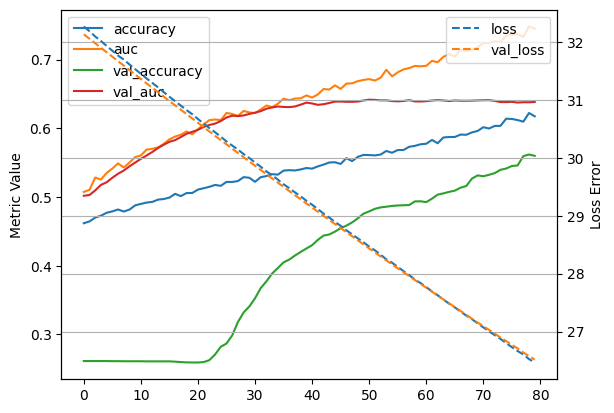

265/265 - 3s - loss: 26.5715 - accuracy: 0.5522 - auc: 0.6668 - 3s/epoch - 13ms/step
Model accuracy: [26.57147789001465, 0.5521877408027649, 0.6667787432670593]
265/265 [==============================] - 4s 13ms/step


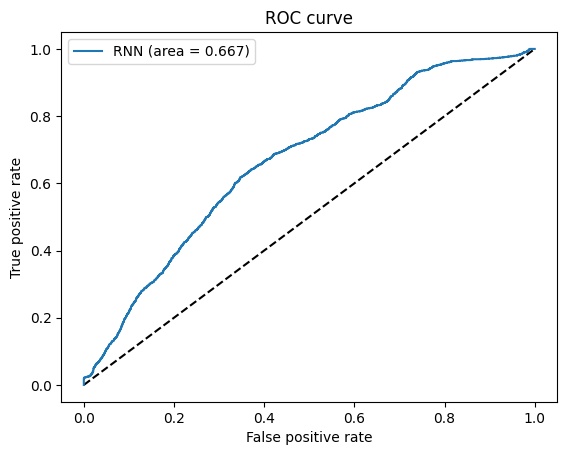

265/265 [==============================] - 4s 14ms/step - loss: 26.5715 - accuracy: 0.5522 - auc: 0.6668
Loss: 26.57147789001465
AUC: 0.5521877408027649
Accuracy: 0.6667787432670593
Precision: 0.3576876756322762
Recall: 0.7490542244640606
Metrics:  ['loss', 'accuracy', 'auc']
Results:  [26.57147789001465, 0.5521877408027649, 0.6667787432670593]


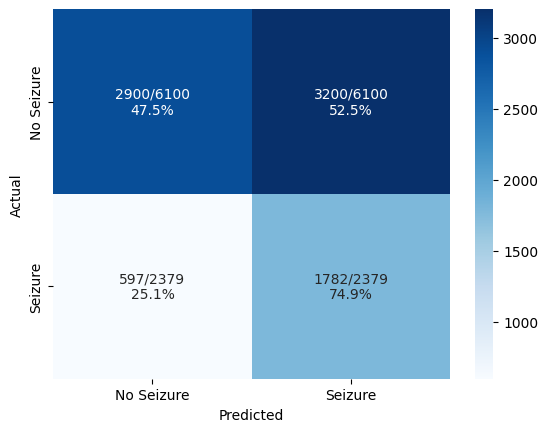

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.48      0.60      6100
         1.0       0.36      0.75      0.48      2379

    accuracy                           0.55      8479
   macro avg       0.59      0.61      0.54      8479
weighted avg       0.70      0.55      0.57      8479



Ein Unterverzeichnis oder eine Datei mit dem Namen "-p" existiert bereits.
Folgender Fehler trat auf: -p.
Ein Unterverzeichnis oder eine Datei mit dem Namen "saved_model" existiert bereits.
Folgender Fehler trat auf: saved_model.


INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit\assets


INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit\assets


In [10]:
%run model_rnn.ipynb